In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
# import timesynth as ts # package for generating time series

import matplotlib.pyplot as plt

import sys

from math import pi

from qolmat.utils import plot, data
from qolmat.imputations.rpca.graph_rpca import GraphRPCA
from qolmat.imputations.rpca.pcp_rpca import PcpRPCA
from qolmat.imputations.rpca.temporal_rpca import TemporalRPCA, OnlineTemporalRPCA

**Generate synthetic data**

In [64]:
n_samples = 1000

mesh = np.arange(n_samples)
X_true = np.zeros(n_samples)
A_true = np.zeros(n_samples)
E_true = np.zeros(n_samples)
p1 = 100
p2 = 20
X_true = 1 + np.sin(2 * pi * mesh / p1) + np.sin(2 * pi * mesh / p2)
noise = np.random.uniform(size=n_samples)
amplitude_A = .5
freq_A = .05
A_true = amplitude_A * np.where(noise < freq_A, -np.log(noise), 0) * (2 * (np.random.uniform(size=n_samples) > .5) - 1)
amplitude_E = .1
E_true = amplitude_E * np.random.normal(size=n_samples)

signal = X_true + E_true
signal[A_true != 0] = A_true[A_true != 0]
signal = signal.reshape(-1, 1)

# Adding missing data
signal[5:20, 0] = np.nan

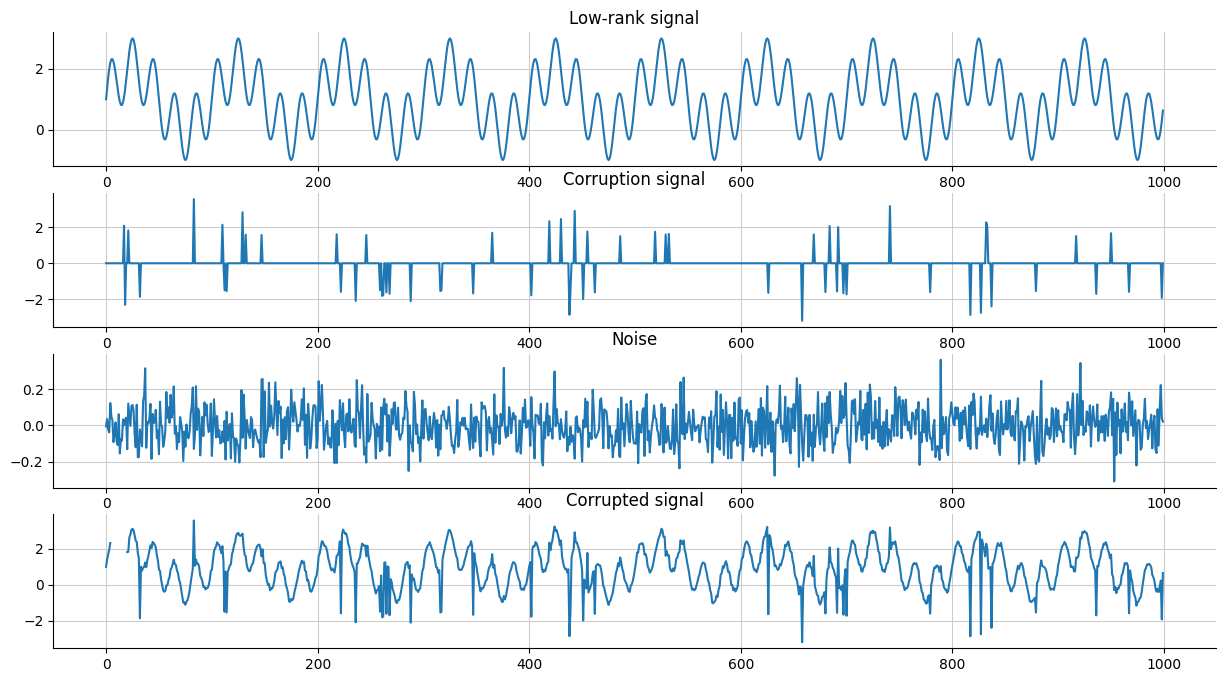

In [65]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(4, 1, 1)
ax.title.set_text("Low-rank signal")
plt.plot(X_true)

ax = fig.add_subplot(4, 1, 2)
ax.title.set_text("Corruption signal")
plt.plot(A_true)

ax = fig.add_subplot(4, 1, 3)
ax.title.set_text("Noise")
plt.plot(E_true)

ax = fig.add_subplot(4, 1, 4)
ax.title.set_text("Corrupted signal")
plt.plot(signal[:, 0])

plt.show()

## PCP RPCA

coucou
D:
[[0.99411255 1.4069981  1.6900432  1.95812196 2.32392978        nan
         nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [1.81906286 1.83114017 2.62857018 2.79817353 3.05655344 3.11332023
  3.03028508 2.75813483 2.4489861  2.39215803]]


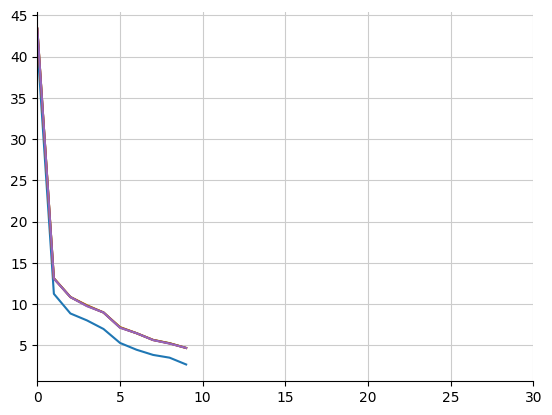

CPU times: user 181 ms, sys: 4.43 ms, total: 185 ms
Wall time: 77.8 ms


In [81]:
%%time

pcp_rpca = PcpRPCA(period=100, max_iter=5, mu=.5, lam=1)
X = pcp_rpca.fit_transform(signal)
corruptions = signal - X

## Temporal RPCA

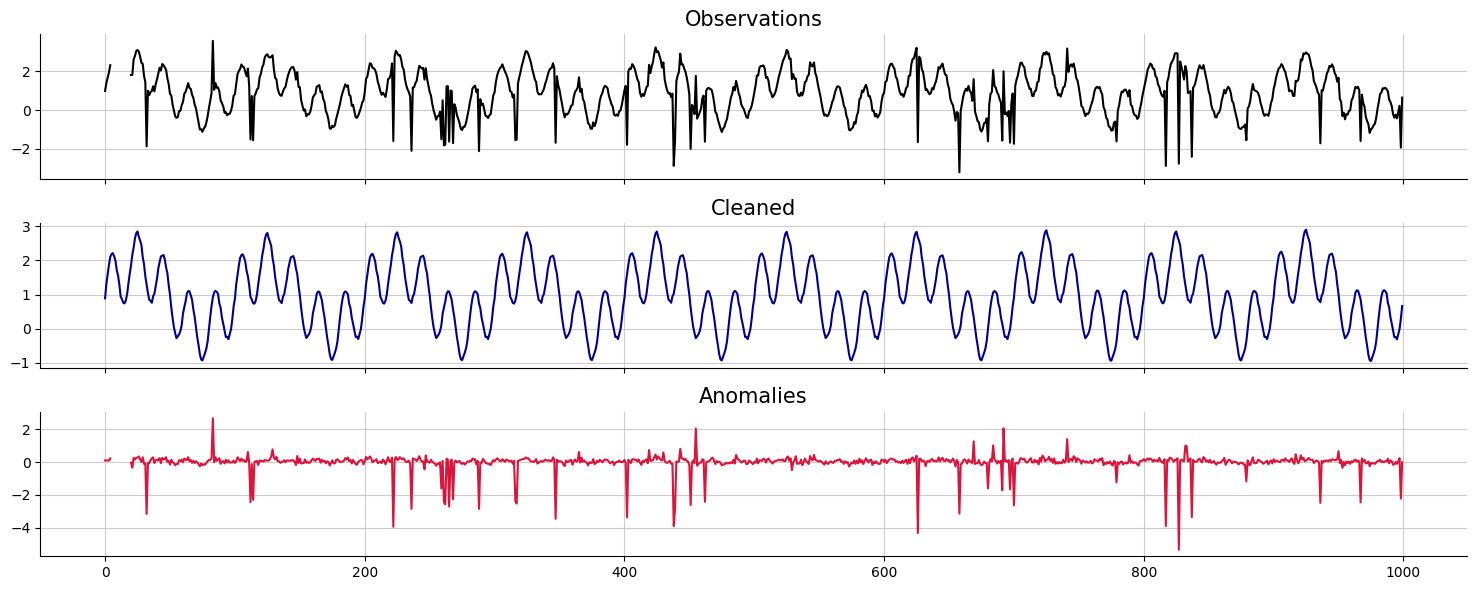

In [83]:
temporal_rpca = TemporalRPCA(period=10, tau=2, lam=0.3, list_periods=[10], list_etas=[0.01], norm="L2")
X = temporal_rpca.fit_transform(signal)
corruptions = signal - X
plot.plot_signal([signal[:,0], X[:,0], corruptions[:, 0]])

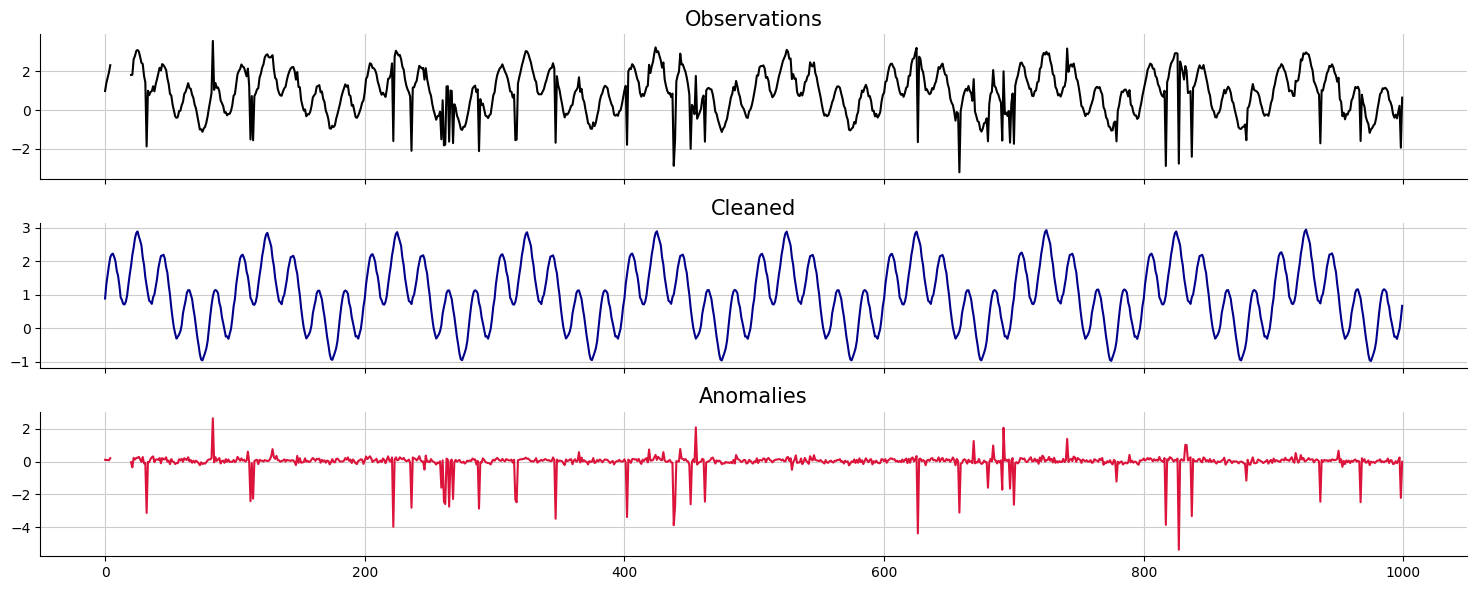

In [84]:
temporal_rpca = TemporalRPCA(period=10, tau=2, lam=0.3, list_periods=[], list_etas=[], norm="L2")
X = temporal_rpca.fit_transform(signal)
corruptions = signal - X
plot.plot_signal([signal[:,0], X[:,0], corruptions[:, 0]])

In [85]:
online_temp_rpca = OnlineTemporalRPCA(period=10, tau=1, lam=0.3, list_periods=[10], list_etas=[0.01],
                       burnin=0.2, online_list_etas=[.3])
X = online_temp_rpca.fit_transform(signal)
corruptions = signal - X
plot.plot_signal([samples[:,0], X[:,0], corruptions[:,0]])

ValueError: operands could not be broadcast together with shapes (10,100) (10,20) (10,20) 

In [ ]:
online_temp_rpca = OnlineTemporalRPCA(n_rows=25, tau=1, lam=0.3, list_periods=[20], list_etas=[0.01],
                       burnin=0.2, online_list_etas=[0.3], nwin=20)
X, A = online_temp_rpca.fit_transform(X=samples)
plot.plot_signal([samples, X, A])

In [ ]:
graph_rpca = GraphRPCA(n_rows=25, gamma1=1, gamma2=1, nbg1=5, nbg2=5)
X, A, _ = graph_rpca.fit_transform(X=samples)
plot.plot_signal([samples, X, A])

In [ ]:
len(A)